<a href="https://colab.research.google.com/github/albertaillet/LELSD/blob/colab-setup/notebooks/experiment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   Clone repo and from correct branch
*   Download the pretrained stylegan2 model from https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/






In [1]:
!git clone --branch colab-setup https://github.com/albertaillet/LELSD/
!wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl -P LELSD/pretrained/stylegan2

Cloning into 'LELSD'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 188 (delta 21), reused 0 (delta 0), pack-reused 139
Receiving objects: 100% (188/188), 31.82 MiB | 3.98 MiB/s, done.
Resolving deltas: 100% (40/40), done.
--2022-04-01 13:26:18--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 143.204.231.104, 143.204.231.77, 143.204.231.29, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|143.204.231.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381624121 (364M) [binary/octet-stream]
Saving to: ‘LELSD/pretrained/stylegan2/ffhq.pkl’

ffhq.pkl            100%[===================>] 363.94M  64.8MB/s    in 5.5s    

2022-04-01 13:26:24 (65.8 MB/s) - ‘LELSD/pretrained/stylegan2/ffhq.pkl’ saved [381624121/381624121]



In [1]:
!pip install -r LELSD/requirements.txt
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ztrbseb_
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-ztrbseb_


In [2]:
%cd LELSD

/content/LELSD


In [3]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")
import sys
import torch

import models
from utils.stylegan2_utils import StyleGAN2SampleGenerator
from utils.segmentation_utils import FaceSegmentation, StuffSegmentation, GANLinearSegmentation
from lelsd import LELSD

# Training StyleGAN2 with Supervised Segmentation

### StyleGAN2 FFHQ

In [6]:
device = torch.device('cuda')
seed = 1

exp_dir = "out"
G2 = models.get_model("stylegan2", "pretrained/stylegan2/ffhq.pkl")
sample_generator = StyleGAN2SampleGenerator(G=G2, device=device)

In [7]:
batch_data = sample_generator.generate_batch(seed, return_image=True, return_style=True, batch_size=1)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


In [32]:
image = batch_data["raw_image"].cpu().numpy().reshape((1024, 1024, 3))

In [35]:
image = (image + 1)*255/2

In [40]:
image.shape

(1024, 1024, 3)

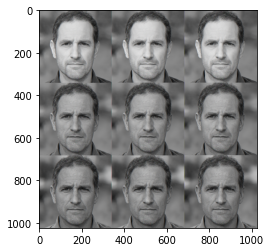

In [38]:
plt.imshow(image.astype(int), )